# Setup
You need to run this the first time

In [ ]:
# install requirements
!pip install -r requirements.txt

# install glide
%cd "glide-text2im"
!pip install -e .
%cd ..

# install glide
%cd "rembg"
!pip install -e .
%cd ..

# install Real-ESRGAN
%cd Real-ESRGAN
# Set up the environment
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
%cd ..

#### If you ran the previous cell, you have to restart the kernel

# Load Models

In [1]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from pathlib import Path
import os
import numpy as np
from rembg.rembg import remove
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

# the upscaler
from upscaler import Upscaler
upscaler = Upscaler()

# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

# create folders
output_folder = "output_images"

Path(f'{output_folder}').mkdir(parents=True, exist_ok=True) 

In [2]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [3]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [4]:
# helper functions

def to_pillow_image(batch: th.Tensor):
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    return Image.fromarray(reshaped.numpy())

def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    img = to_pillow_image(batch)
    display(img)

def save_image(batch: th.Tensor, path: str):
    img = to_pillow_image(batch)
    img.save(path)

def read_image(path: str, size: int = 256) -> tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.Resampling.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

# Generate the image

### Parameters

In [51]:
# Sampling parameters

# text prompt
prompt = "a poster of a colorful flowers"

# adding some keywords to help with the image generation
prompt = f'{prompt}, carton realistic, very detailed'

batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

### Generation

100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


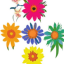

In [53]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

### Upsampling

100%|██████████| 27/27 [00:05<00:00,  5.29it/s]


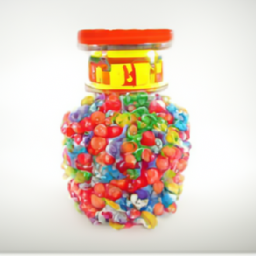

In [30]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

### Upscaling

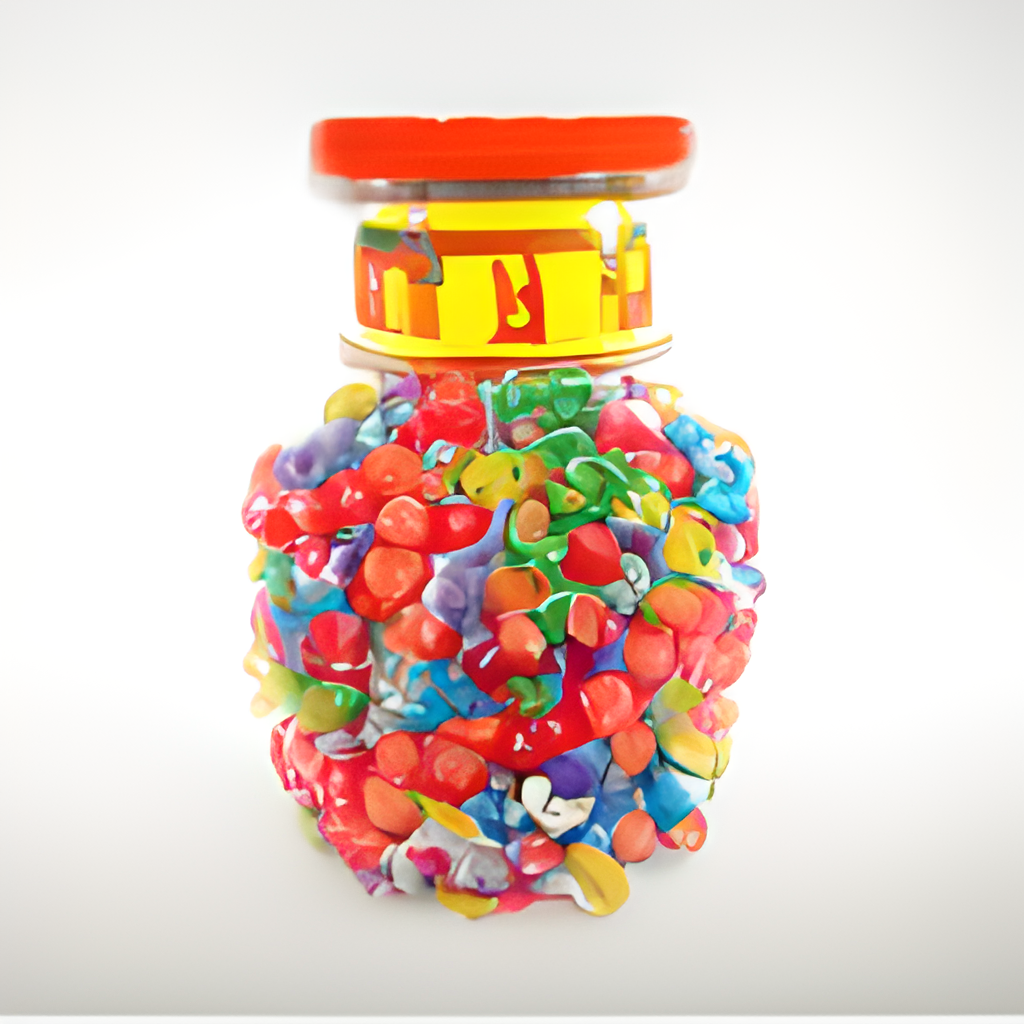

In [34]:
upscaled_img = upscaler.upscale(up_samples)
show_images(upscaled_img)

### Removing the background

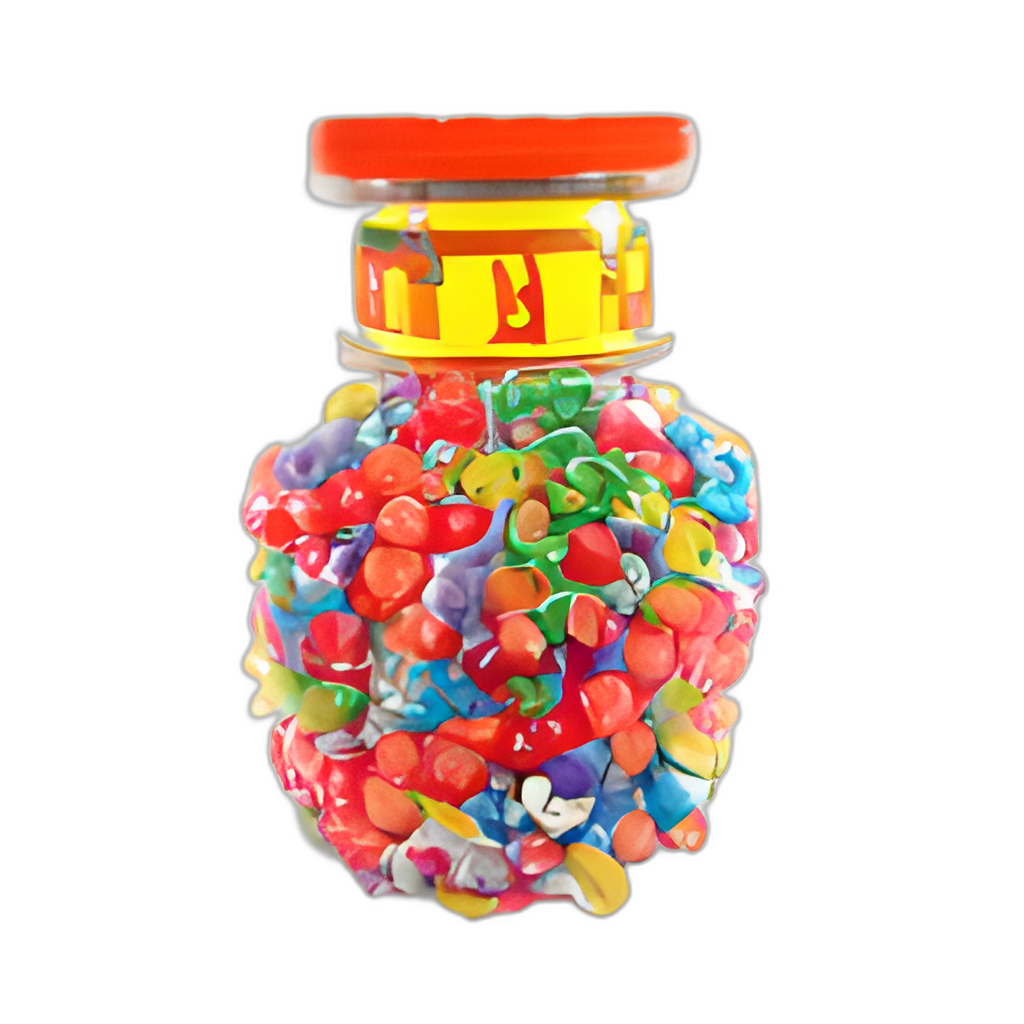

In [46]:
pil_img = to_pillow_image(upscaled_img)
no_bg = remove(pil_img)
no_bg

### Saving the image

In [47]:
import glob
arr = [int(Path(file).stem) for file in glob.glob(output_folder+"/*") if Path(file).stem.isdigit()]+[-1]   # [-1] in case the folder is empty 
save_name = f"{(max(arr)+1)}.png"
save_path = f"{output_folder}/{save_name}"
no_bg.save(save_path)
print(f"image saved {save_path}")

image saved output_images/6.png
